In [10]:
import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
%reload_ext autoreload
%autoreload 2

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
%matplotlib inline

import gc
gc.enable()
base_dir = '/home/ubuntu//off/home-credit-default-risk/data/'
from functions import utils
from pathlib import Path
from functions.prepare import (prepare_bureau, prepare_previous_application, 
                               prepare_train_test, one_hot_encoder,
                               prepare_pos_cash, prepare_installments_payments,
                              prepare_credit_card_balance, timer)

from functions.cv_lgbm import train_model_LGBM

base_dir = Path(base_dir)

In [3]:
def main():
    application_train, application_test, y, categorical_feats = prepare_train_test(base_dir, 
                                                                                   encode_categories='OHE')
    unique_curr = set(application_test.SK_ID_CURR) | set(application_train.SK_ID_CURR)
    application_train.set_index('SK_ID_CURR', inplace = True)
    application_test.set_index('SK_ID_CURR', inplace = True)
    
    with timer("Process bureau and bureau_balance"):
        bureau = prepare_bureau(base_dir)
        print("Bureau bureau shape:", bureau.shape)
        application_train = application_train.join(bureau, how='left')
        application_test = application_test.join(bureau, how='left')
        del bureau
        gc.collect()
    with timer("Process previous_applications"):
        previous_application = prepare_previous_application(base_dir, unique_curr)
        print("Previous applications df shape:", previous_application.shape)
        application_train = application_train.join(previous_application, how='left')
        application_test = application_test.join(previous_application, how='left')
        del previous_application
        gc.collect()
    with timer("Process POS-CASH balance"):
        pos = prepare_pos_cash(base_dir)
        print("Pos-cash balance df shape:", pos.shape)
        application_train = application_train.join(pos, how='left')
        application_test = application_test.join(pos, how='left')
        del pos
        gc.collect()
    with timer("Process installments payments"):
        installments = prepare_installments_payments(base_dir)
        print("Installments payments df shape:", installments.shape)
        application_train = application_train.join(installments, how='left')
        application_test = application_test.join(installments, how='left')
        del installments
        gc.collect()
    with timer("Process credit card balance"):
        credit_card = prepare_credit_card_balance(base_dir)
        print("Credit card balance df shape:", credit_card.shape)
        application_train = application_train.join(credit_card, how='left')
        application_test = application_test.join(credit_card, how='left')
        del credit_card
        gc.collect()
    return application_train.reset_index(), application_test.reset_index(), y


with timer("Full model run"):
    application_train, application_test, y = main()

/home/ubuntu/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2910: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Initial test 
(48744, 121) 121
Initial train 
(307511, 122) 122
Final test 
(48744, 265) 265
Final train 
(307511, 265) 265
bureau_balance shape :  (27299925, 11) - unique 817395
Bureau bureau shape: (305811, 95)
Process bureau and bureau_balance - done in 25s
(1670214, 37)
remove Canceled, it seems that there is always a new application after those canceled
(1353895, 37)
Only in test/train set
Only in test/train set,  (1353895, 37)
Final, 
(338602, 203) 203
Previous applications df shape: (338602, 203)
Process previous_applications - done in 19s
pos_cash shape :  (10001358, 8)
pos_cash shape :  (337252, 19)
Pos-cash balance df shape: (337252, 19)
Process POS-CASH balance - done in 14s
installments shape :  (339587, 36)
Installments payments df shape: (339587, 36)
Process installments payments - done in 35s
credit card shape :  (103558, 113)
Credit card balance df shape: (103558, 113)
Process credit card balance - done in 17s
Full model run - done in 118s


In [4]:
application_train.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NEW_CREDIT_TO_ANNUITY_RATIO,NEW_CREDIT_TO_GOODS_RATIO,NEW_DOC_IND_KURT,NEW_LIVE_IND_SUM,NEW_INC_PER_CHLD,NEW_INC_BY_ORG,NEW_EMPLOY_TO_BIRTH_RATIO,NEW_ANNUITY_TO_INCOME_RATIO,NEW_SOURCES_PROD,NEW_EXT_SOURCES_MEAN,NEW_SCORES_STD,NEW_CAR_TO_BIRTH_RATIO,NEW_CAR_TO_EMPLOY_RATIO,NEW_PHONE_TO_BIRTH_RATIO,NEW_PHONE_TO_BIRTH_RATIO_EMPLOYER,NEW_CREDIT_TO_INCOME_RATIO,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_TYPE_SUITE_nan,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_INCOME_TYPE_nan,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_EDUCATION_TYPE_nan,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,NAME_FAMILY_STATUS_nan,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,NAME_HOUSING_TYPE_nan,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/

In [5]:
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [23]:
oof_preds, df_oof_preds, test_preds, importances, score = train_model_LGBM(application_train, 
                                                                           y['TARGET'], application_test,
                                                                           folds , 
                                                                           ignore_cols_=missing_featuresmissing+['SK_ID_CURR'])

Training until validation scores don't improve for 100 rounds.
[50]	training's auc: 0.748645	valid_1's auc: 0.737321
[100]	training's auc: 0.757364	valid_1's auc: 0.742777
[150]	training's auc: 0.769604	valid_1's auc: 0.751533
[200]	training's auc: 0.781443	valid_1's auc: 0.75987
[250]	training's auc: 0.792159	valid_1's auc: 0.76726
[300]	training's auc: 0.80016	valid_1's auc: 0.77198
[350]	training's auc: 0.806997	valid_1's auc: 0.775493
[400]	training's auc: 0.812935	valid_1's auc: 0.778165
[450]	training's auc: 0.818256	valid_1's auc: 0.780314
[500]	training's auc: 0.823003	valid_1's auc: 0.781806
[550]	training's auc: 0.827291	valid_1's auc: 0.783026
[600]	training's auc: 0.831409	valid_1's auc: 0.783961
[650]	training's auc: 0.835447	valid_1's auc: 0.784992
[700]	training's auc: 0.839011	valid_1's auc: 0.785638
[750]	training's auc: 0.842613	valid_1's auc: 0.786241
[800]	training's auc: 0.846121	valid_1's auc: 0.786704
[850]	training's auc: 0.849233	valid_1's auc: 0.787125
[900]	t

[1200]	training's auc: 0.869895	valid_1's auc: 0.78822
[1250]	training's auc: 0.872655	valid_1's auc: 0.788324
[1300]	training's auc: 0.87533	valid_1's auc: 0.788378
[1350]	training's auc: 0.877894	valid_1's auc: 0.788461
[1400]	training's auc: 0.880175	valid_1's auc: 0.788557
[1450]	training's auc: 0.882538	valid_1's auc: 0.788552
[1500]	training's auc: 0.884862	valid_1's auc: 0.788538
[1550]	training's auc: 0.887093	valid_1's auc: 0.788487
Early stopping, best iteration is:
[1472]	training's auc: 0.883591	valid_1's auc: 0.788614
Fold  4 AUC : 0.788614
Training until validation scores don't improve for 100 rounds.
[50]	training's auc: 0.745897	valid_1's auc: 0.739536
[100]	training's auc: 0.755277	valid_1's auc: 0.747174
[150]	training's auc: 0.767848	valid_1's auc: 0.757209
[200]	training's auc: 0.779654	valid_1's auc: 0.765552
[250]	training's auc: 0.790607	valid_1's auc: 0.77264
[300]	training's auc: 0.799087	valid_1's auc: 0.777424
[350]	training's auc: 0.805938	valid_1's auc: 0.7

In [24]:
# Save test predictions
now = datetime.now()
score = str(round(score, 6)).replace('.', '')
sub_file = 'subs/submission_5x-average-LGB-run-01-v1_' + score + '_' + str(now.strftime('%Y-%m-%d-%H-%M')) + '.csv.gz'
test_preds.to_csv(sub_file, index=False, compression  = 'gzip' )
oof_file = 'subs/train_5x-LGB-run-01-v1-oof_' + score + '_' + str(now.strftime('%Y-%m-%d-%H-%M')) + '.csv.gz'
df_oof_preds.to_csv(oof_file, index=False, compression  = 'gzip')
# Display a few graphs

In [25]:
folds_idx = [(trn_idx, val_idx)
             for trn_idx, val_idx in folds.split(application_train, y['TARGET'])]

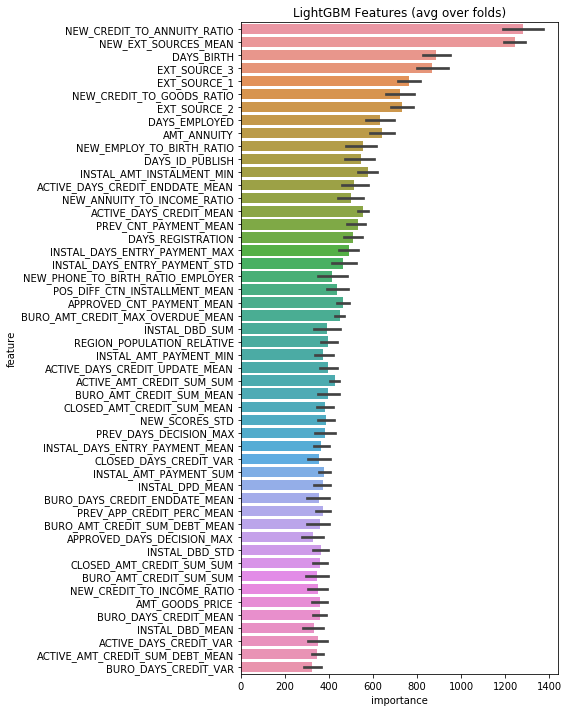

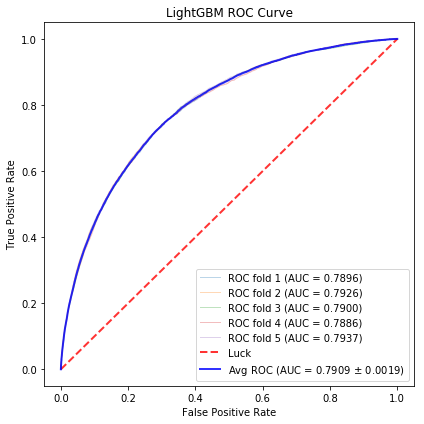

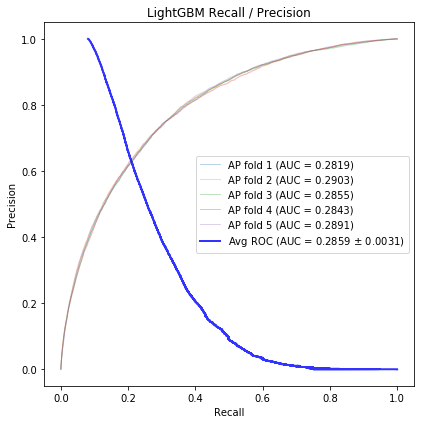

In [26]:
utils.display_importances(feature_importance_df_=importances)
utils.display_roc_curve(y_=y['TARGET'], oof_preds_=oof_preds, folds_idx_=folds_idx)
utils.display_precision_recall(y_=y['TARGET'], oof_preds_=oof_preds, folds_idx_=folds_idx)

In [27]:
!!kaggle competitions submit -c home-credit-default-risk -f {sub_file} -m "LGBM 750 features cv5"

['Successfully submitted to Home Credit Default Risk']

In [17]:
from functions.feature_selector import FeatureSelector

In [18]:
fs = FeatureSelector(data = application_train, labels = y['TARGET'])

In [19]:
fs.identify_missing(missing_threshold=0.6)

177 features with greater than 0.60 missing values.



In [21]:
missing_featuresmissing  = fs.ops['missing']

In [22]:
missing_featuresmissing

['OWN_CAR_AGE',
 'YEARS_BUILD_AVG',
 'COMMONAREA_AVG',
 'FLOORSMIN_AVG',
 'LIVINGAPARTMENTS_AVG',
 'NONLIVINGAPARTMENTS_AVG',
 'YEARS_BUILD_MODE',
 'COMMONAREA_MODE',
 'FLOORSMIN_MODE',
 'LIVINGAPARTMENTS_MODE',
 'NONLIVINGAPARTMENTS_MODE',
 'YEARS_BUILD_MEDI',
 'COMMONAREA_MEDI',
 'FLOORSMIN_MEDI',
 'LIVINGAPARTMENTS_MEDI',
 'NONLIVINGAPARTMENTS_MEDI',
 'NEW_SOURCES_PROD',
 'NEW_CAR_TO_BIRTH_RATIO',
 'NEW_CAR_TO_EMPLOY_RATIO',
 'BURO_AMT_ANNUITY_MAX',
 'BURO_AMT_ANNUITY_MEAN',
 'BURO_MONTHS_BALANCE_MIN_MIN',
 'BURO_MONTHS_BALANCE_MAX_MAX',
 'BURO_MONTHS_BALANCE_SIZE_MEAN',
 'BURO_STATUS_0_MEAN_MEAN',
 'BURO_STATUS_1_MEAN_MEAN',
 'BURO_STATUS_2_MEAN_MEAN',
 'BURO_STATUS_3_MEAN_MEAN',
 'BURO_STATUS_4_MEAN_MEAN',
 'BURO_STATUS_5_MEAN_MEAN',
 'BURO_STATUS_C_MEAN_MEAN',
 'BURO_STATUS_X_MEAN_MEAN',
 'BURO_STATUS_nan_MEAN_MEAN',
 'ACTIVE_AMT_CREDIT_MAX_OVERDUE_MEAN',
 'ACTIVE_AMT_ANNUITY_MAX',
 'ACTIVE_AMT_ANNUITY_MEAN',
 'ACTIVE_MONTHS_BALANCE_MIN_MIN',
 'ACTIVE_MONTHS_BALANCE_MAX_MAX',
 'A